In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# !pip install xgboost

In [3]:
import xgboost
from dateutil.relativedelta import relativedelta
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print("xgboost", xgboost.__version__)


xgboost 0.90


root_path - path to the folder with your csv file. filenam name of the csv file with the dataset.

In [4]:
root_path = 'gdrive/MyDrive/Colab Notebooks/'
path = Path(root_path)
filename = 'final_.csv'

Read file to DataFrame

In [5]:
df_final = pd.read_csv(path/filename, dtype={'line_total_order_qty' : int, 'dock_imp_day' : "string"})

In [6]:
df_final
df_final= df_final[df_final['spend_total_demand_generation'] != -999]
df_final[df_final.spend_total_demand_generation == -999].count()


date                                       0
days_until_promo_ends                      0
next_us_hday                               0
prev_us_hday                               0
month                                      0
month_day                                  0
week_day                                   0
days_until_payday                          0
pc9                                        0
gender                                     0
size_group                                 0
style                                      0
interacted_price                           0
pricing                                    0
pc3                                        0
pc5                                        0
category                                   0
product_item_type                          0
fit                                        0
regular_price                              0
overall                                    0
reg                                        0
mk        

In [7]:
df_final['date'] = pd.to_datetime(df_final['date'])

In [8]:
df_final['spend_paid_social'] =df_final['spend_paid_social']/df_final['spend_total_demand_generation']
df_final['spend_paid_search'] =df_final['spend_paid_search']/df_final['spend_total_demand_generation']
df_final['spend_affiliate'] =df_final['spend_affiliate']/df_final['spend_total_demand_generation']
df_final['spend_cses'] =df_final['spend_cses']/df_final['spend_total_demand_generation']
df_final['spend_display'] =df_final['spend_display']/df_final['spend_total_demand_generation']


In [9]:
# drop from the data LM_units with -999 (n/a) values
df_final= df_final[df_final['LM_unit_sold_monthly_mean'] != -999]

# Calculate different in pricing from MSRP, this field is already in the final_.csv. Needs only for original file
# df_final['dis_from_msrp'] = ((df_final['regular_price'] - df_final['possible_final_price']) / df_final['regular_price'])

# Set reg, mk and overall not in % by dividing on 100 May be it;s not nescessary. IMHO this features are not important in out model 
df_final['reg'] =df_final['reg']/100
df_final['mk'] =df_final['mk']/100
df_final['overall'] =df_final['overall']/100

# change name of the week with numbers 0..6
df_final['week_day'] = pd.to_datetime(df_final['date']).dt.dayofweek

# Add column with the week from the first date we have in dataframe.
# Used this to calculate mean of line_total_order_qty.
# Fot the training of the model going to try to use not the sales for one day,
# but instead an average sales of the product for the week.
df_final['period'] = ((pd.to_datetime(df_final['date']) - pd.to_datetime('2018-03-31')).dt.days/7).astype(int)
df_final['avg_toq_per_week'] = df_final.groupby(['pc9', 'period'])['line_total_order_qty'].transform('mean')


df_final['dock_imp_day']= df_final['dock_imp_day'].astype(str)

In [10]:
def time_encoding(series, freq, max_val=None):
    """Transforms a pandas series of dtype datetime64 (of any freq) or DatetimeIndex into 2 float arrays
    Available options: microsecond, millisecond, second, minute, hour, day = day_of_month = dayofmonth,
    day_of_week = weekday = dayofweek, day_of_year = dayofyear, week = week_of_year = weekofyear, month and year
    """

    if freq == 'day_of_week' or freq == 'weekday': freq = 'dayofweek'
    elif freq == 'day_of_month' or freq == 'dayofmonth': freq = 'day'
    elif freq == 'day_of_year': freq = 'dayofyear'
    available_freqs = ['microsecond', 'millisecond', 'second', 'minute', 'hour', 'day', 'dayofweek', 'dayofyear', 'week', 'month', 'year']
    assert freq in available_freqs
    if max_val is None:
        idx = available_freqs.index(freq)
        max_val = [1_000_000, 1_000, 60, 60, 24, 31, 7, 366, 53, 12, 10][idx]
    try:
        series = series.to_series()
    except:
        pass
    if freq == 'microsecond': series = series.dt.microsecond
    elif freq == 'millisecond': series = series.dt.microsecond // 1_000
    elif freq == 'second': series = series.dt.second
    elif freq == 'minute': series = series.dt.minute
    elif freq == 'hour': series = series.dt.hour
    elif freq == 'day': series = series.dt.day
    elif freq == 'dayofweek': series = series.dt.dayofweek
    elif freq == 'dayofyear': series = series.dt.dayofyear
    elif freq == 'week': series = series.dt.isocalendar().week
    elif freq == 'month': series = series.dt.month
    elif freq == 'year': series = series.dt.year - series.dt.year // 10 * 10
    sin = np.sin(series.values / max_val * 2 * np.pi)
    cos = np.cos(series.values / max_val * 2 * np.pi)
    return sin, cos

In [11]:
month_sin, month_cos  = time_encoding(df_final['date'], freq = 'month')
df_final['month_sin'] = month_sin
df_final['month_cos'] = month_cos
month_sin, month_cos
day_sin, day_cos  = time_encoding(df_final['date'], freq = 'day')
df_final['month_day_sin'] = day_sin
df_final['month_day_cos'] = day_cos
week_day_sin, week_day_cos  = time_encoding(df_final['date'], freq = 'dayofweek')
df_final['week_day_sin'] = week_day_sin
df_final['week_day_cos'] = week_day_cos

df_final.head()

,date,days_until_promo_ends,next_us_hday,prev_us_hday,month,month_day,week_day,days_until_payday,pc9,gender,size_group,style,interacted_price,pricing,pc3,pc5,category,product_item_type,fit,regular_price,overall,reg,mk,major_minimum_value,major_multiple_items,site_wide,upto,special,markdown,non_markdown,spend_paid_social,spend_paid_search,spend_affiliate,spend_cses,spend_display,spend_total_demand_generation,dock_imp_day,pricing_period,possible_final_price,selected,LM_unit_sold_monthly_mean,LM_unit_sold_monthly_sum_rolling_mean_3,LM_overall_unit_sold_monthly_mean,line_total_order_qty,dis_from_msrp,period,avg_toq_per_week,month_sin,month_cos,month_day_sin,month_day_cos,week_day_sin,week_day_cos
19644,2018-04-30,0.0,28.0,70.0,4.0,30.0,0,0.0,38,0,1,26,32.97,0,9,12,2,10,7,58.0,0.2,0.25,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12491,0.582862,0.163678,0.12855,0.0,164310.0,-999,1,26.376,0.0,3.0,1.333333,2.311538,2,0.545241,4,0.4,0.866025,-0.5,-0.201299,0.97953,0.0,1.0
19646,2018-04-30,0.0,28.0,70.0,4.0,30.0,0,0.0,43,0,1,33,58.00,1,11,15,2,10,1,58.0,0.2,0.25,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12491,0.582862,0.163678,0.12855,0.0,164310.0,-999,1,43.500,0.0,2.0,3.000000,2.311538,3,0.250000,4,2.4,0.866025,-0.5,-0.201299,0.97953,0.0,1.0
19647,2018-04-30,0.0,28.0,70.0,4.0,30.0,0,0.0,44,0,1,33,58.00,1,11,15,2,10,1,58.0,0.2,0.25,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12491,0.582862,0.163678,0.12855,0.0,164310.0,-999,1,43.500,0.0,4.0,5.666667,2.311538,1,0.250000,4,1.2,0.866025,-0.5,-0.201299,0.97953,0.0,1.0
19648,2018-04-30,0.0,28.0,70.0,4.0,30.0,0,0.0,45,0,1,33,58.00,1,11,15,2,10,1,58.0,0.2,0.25,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12491,0.582862,0.163678,0.12855,0.0,164310.0,-999,1,43.500,0.0,1.0,2.666667,2.311538,3,0.250000,4,2.2,0.866025,-0.5,-0.201299,0.97953,0.0,1.0
19649,2018-04-30,0.0,28.0,70.0,4.0,30.0,0,0.0,46,0,1,33,32.97,0,11,15,2,10,1,58.0,0.2,0.25,0.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.12491,0.582862,0.163678,0.12855,0.0,164310.0,-999,1,26.376,0.0,1.0,3.333333,2.311538,3,0.545241,4,2.8,0.866025,-0.5,-0.201299,0.97953,0.0,1.0


In [12]:
df_final.columns

Index(['date', 'days_until_promo_ends', 'next_us_hday', 'prev_us_hday',
       'month', 'month_day', 'week_day', 'days_until_payday', 'pc9', 'gender',
       'size_group', 'style', 'interacted_price', 'pricing', 'pc3', 'pc5',
       'category', 'product_item_type', 'fit', 'regular_price', 'overall',
       'reg', 'mk', 'major_minimum_value', 'major_multiple_items', 'site_wide',
       'upto', 'special', 'markdown', 'non_markdown', 'spend_paid_social',
       'spend_paid_search', 'spend_affiliate', 'spend_cses', 'spend_display',
       'spend_total_demand_generation', 'dock_imp_day', 'pricing_period',
       'possible_final_price', 'selected', 'LM_unit_sold_monthly_mean',
       'LM_unit_sold_monthly_sum_rolling_mean_3',
       'LM_overall_unit_sold_monthly_mean', 'line_total_order_qty',
       'dis_from_msrp', 'period', 'avg_toq_per_week', 'month_sin', 'month_cos',
       'month_day_sin', 'month_day_cos', 'week_day_sin', 'week_day_cos'],
      dtype='object')

Will use one item for the model prediction. 

In [13]:
# pc9 = 832

In [14]:
df_final.date.max()

Timestamp('2021-08-06 00:00:00')

In [15]:
df_final['date'].max() - relativedelta(months=12)

Timestamp('2020-08-06 00:00:00')

In [16]:
# df_pc9=df_final[df_final.pc9 == pc9].copy()


In [17]:
# df_pc9.shape[1]

In [18]:
def train_val_split(df_data, date_col = 'date', months=2):
    df_data[date_col] = pd.to_datetime(df_data[date_col])
    split_date = df_data[date_col].max() - relativedelta(months=months)
    end_split_date = df_data[date_col].max() - relativedelta(months=months-1)
    print ('Validation from {} to {}'.format(split_date, end_split_date))
    df_train = df_data[df_data[date_col] < split_date]
    df_val = df_data[(df_data[date_col] >= split_date) & (df_data[date_col] < end_split_date)]
    # df_val = df_val[df_val[date_col] < end_split_date]
    return df_train, df_val


In [19]:
features = ['pc9', 'days_until_promo_ends', 'next_us_hday', 'prev_us_hday', 'interacted_price', 'pricing', 'regular_price', 'spend_paid_social',
       'spend_paid_search', 'spend_affiliate', 'spend_cses', 'spend_display', 'special', 'pricing_period', 'possible_final_price', 'selected', 'month_sin', 'month_cos',
       'month_day_sin', 'month_day_cos', 'week_day_sin', 'week_day_cos','dis_from_msrp',
        # 'avg_toq_per_week',
        'LM_unit_sold_monthly_mean',
       'line_total_order_qty']

In [20]:
def walk_forward (model, df_data, date_col = 'date', features = features, months=6, steep = 1):
    for i in range(months,0, -1):
        print(i)
        df_train, df_val = train_val_split(df_data, date_col=date_col, months=i)
        data_train = df_train[features].copy()
        data_val = df_val[features].copy()
        data_train = np.asarray(data_train)
        data_val = np.asarray(data_val)
        # split into input and output columns
        trainX, trainy = data_train[:, :-1], data_train[:, -1]
        valX, valy = data_val[:, :-1], data_val[:, -1]
        model.fit(trainX, trainy)
        yhat = model.predict(valX)
        print ('MAE: ', mean_absolute_error(valy, yhat))
        print ('RMSE: ', mean_squared_error(valy, yhat, squared=False))
        print ('Total validation {}. Total predicted {}'.format(valy.sum(), yhat.sum()))
        print ((yhat.sum()-valy.sum())/valy.sum())


In [21]:
def feature_importance(model, data):
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

In [22]:
df_train, df_val = train_val_split(df_final, date_col='date', months=6)
df_val

Validation from 2021-02-06 00:00:00 to 2021-03-06 00:00:00


,date,days_until_promo_ends,next_us_hday,prev_us_hday,month,month_day,week_day,days_until_payday,pc9,gender,size_group,style,interacted_price,pricing,pc3,pc5,category,product_item_type,fit,regular_price,overall,reg,mk,major_minimum_value,major_multiple_items,site_wide,upto,special,markdown,non_markdown,spend_paid_social,spend_paid_search,spend_affiliate,spend_cses,spend_display,spend_total_demand_generation,dock_imp_day,pricing_period,possible_final_price,selected,LM_unit_sold_monthly_mean,LM_unit_sold_monthly_sum_rolling_mean_3,LM_overall_unit_sold_monthly_mean,line_total_order_qty,dis_from_msrp,period,avg_toq_per_week,month_sin,month_cos,month_day_sin,month_day_cos,week_day_sin,week_day_cos
683165,2021-02-06,9.0,9.0,19.0,2.0,6.0,5,22.0,0,0,1,25,64.97,0,0,0,2,10,7,84.0,0.3,0.15,0.55,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.134027,0.502768,0.091891,0.246223,0.025090,183500.0,-999,1,29.2365,0.0,0.580645,13.333333,1.598396,0,0.651946,149,1.285714,0.866025,5.000000e-01,0.937752,0.347305,-0.974928,-0.222521
683166,2021-02-06,9.0,9.0,19.0,2.0,6.0,5,22.0,4,0,1,0,59.97,0,1,1,4,13,7,79.5,0.3,0.15,0.55,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.134027,0.502768,0.091891,0.246223,0.025090,183500.0,-999,1,26.9865,0.0,1.000000,12.666667,1.598396,1,0.660547,149,0.714286,0.866025,5.000000e-01,0.937752,0.347305,-0.974928,-0.222521
683167,2021-02-06,9.0,9.0,19.0,2.0,6.0,5,22.0,5,0,1,0,59.97,0,1,1,4,13,7,79.5,0.3,0.15,0.55,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.134027,0.502768,0.091891,0.246223,0.025090,183500.0,-999,1,26.9865,0.0,0.677419,20.000000,1.598396,0,0.660547,149,0.285714,0.866025,5.000000e-01,0.937752,0.347305,-0.974928,-0.222521
683168,2021-02-06,9.0,9.0,19.0,2.0,6.0,5,22.0,7,0,1,0,19.97,0,3,3,3,15,0,65.0,0.3,0.15,0.55,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.134027,0.502768,0.091891,0.246223,0.025090,183500.0,-999,1,8.9865,0.0,1.193548,30.000000,1.598396,0,0.861746,149,1.571429,0.866025,5.000000e-01,0.937752,0.347305,-0.974928,-0.222521
683169,2021-02-06,9.0,9.0,19.0,2.0,6.0,5,22.0,9,0,1,0,19.97,0,3,3,3,15,0,65.0,0.3,0.15,0.55,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.134027,0.502768,0.091891,0.246223,0.025090,183500.0,-999,1,8.9865,0.0,0.387097,27.333333,1.598396,0,0.861746,149,0.285714,0.866025,5.000000e-01,0.937752,0.347305,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696305,2021-03-05,2.0,87.0,18.0,3.0,5.0,4,26.0,2021,0,1,14,54.99,2,143,471,2,10,10,78.0,0.4,0.40,0.40,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.039577,0.563962,0.128165,0.243960,0.024336,244536.0,Mystery sale,1,32.9940,0.0,1.714286,21.000000,1.732742,0,0.577000,152,1.428571,1.000000,6.123234e-17,0.848644,0.528964,-0.433884,-0.900969
696306,2021-03-05,2.0,87.0,18.0,3.0,5.0,4,26.0,2022,0,1,14,78.00,1,143,471,2,10,10,78.0,0.4,0.40,0.40,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.039577,0.563962,0.128165,0.243960,0.024336,244536.0,Mystery sale,1,46.8000,0.0,1.464286,36.333333,1.732742,3,0.400000,152,1.000000,1.000000,6.123234e-17,0.848644,0.528964,-0.433884,-0.900969
696307,2021-03-05,2.0,87.0,18.0,3.0,5.0,4,26.0,2023,0,1,14,78.00,1,143,471,2,10,10,78.0,0.4,0.40,0.40,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.039577,0.563962,0.128165,0.243960,0.024336,244536.0,Mystery sale,1,46.8000,0.0,3.178571,50.333333,1.732742,1,0.400000,152,2.571429,1.000000,6.123234e-17,0.848644,0.528964,-0.433884,-0.900969
696310,2021-03-05,2.0,87.0,18.0,3.0,5.0,4,26.0,2043,1,2,0,78.00,1,147,481,2,10,6,78.0,0.4,0.40,0.40,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.039577,0.563962,0.128165,0.243960,0.024336,244536.0,Mystery sale,1,46.8000,0.0,0.000000,36.666667,1.732742,0,0.400000,152,0.000000,1.000000,6.123234e-17,0.848644,0.528964,-0.433884,-0.900969


In [23]:
model = xgboost.XGBRegressor(objective='count:poisson', n_estimators=1000, learning_rate=0.02, max_depth=6)

In [24]:
walk_forward(model, df_final, date_col = 'date', features = features, months=6, steep = 1)
# data = df_final[features].copy()
# data.tail(10)


6
Validation from 2021-02-06 00:00:00 to 2021-03-06 00:00:00
MAE:  1.5703647331198607
RMSE:  3.6796782546197075
Total validation 23375.0. Total predicted 24956.3359375
0.06765073529411765
5
Validation from 2021-03-06 00:00:00 to 2021-04-06 00:00:00
MAE:  1.4520461685105663
RMSE:  2.9675725212579502
Total validation 31456.0. Total predicted 26761.373046875
-0.14924424444064727
4
Validation from 2021-04-06 00:00:00 to 2021-05-06 00:00:00
MAE:  1.5359594667265852
RMSE:  3.125153301802729
Total validation 31802.0. Total predicted 32173.501953125
0.01168171665697126
3
Validation from 2021-05-06 00:00:00 to 2021-06-06 00:00:00
MAE:  1.8125411525526172
RMSE:  4.9353401738745815
Total validation 41417.0. Total predicted 37129.17578125
-0.10352812175555931
2
Validation from 2021-06-06 00:00:00 to 2021-07-06 00:00:00
MAE:  1.9708713900210248
RMSE:  4.445913780328842
Total validation 45484.0. Total predicted 39127.58203125
-0.13975063689978895
1
Validation from 2021-07-06 00:00:00 to 2021-08-06 0

In [40]:
# split_date = '2021-06-06'
# df_train = df_final[df_final['date'] < pd.to_datetime(split_date)]
# df_val = df_final[df_final['date'] >= pd.to_datetime(split_date)]

data_train = df_train[features].copy()
data_val = df_val[features].copy()
# data_train = data[:int(data.shape[0]*0.70)]
# data_val = data[int(data.shape[0]*0.70):]


In [41]:
data_t = np.asarray(data_train)
data_v = np.asarray(data_val)
# split into input and output columns
trainX, trainy = data_t[:, :-1], data_t[:, -1]
valX, valy = data_v[:, :-1], data_v[:, -1]

In [42]:
model.fit(trainX, trainy)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='count:poisson', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [47]:
yhat = model.predict(valX)

In [48]:
len(yhat)

12521

In [ ]:
mean_absolute_error(valy, yhat)

In [ ]:
mean_squared_error(valy, yhat, squared=False)

,imp,col
20,4.196589e-21,week_day_sin
12,8.192652e-21,special
21,1.138831e-20,week_day_cos
14,2.364015e-20,possible_final_price
8,2.772862e-20,spend_paid_search
17,4.934299e-20,month_cos
5,5.130517e-20,pricing
9,7.109605e-20,spend_affiliate
11,7.640603e-20,spend_display
15,1.113985e-19,selected


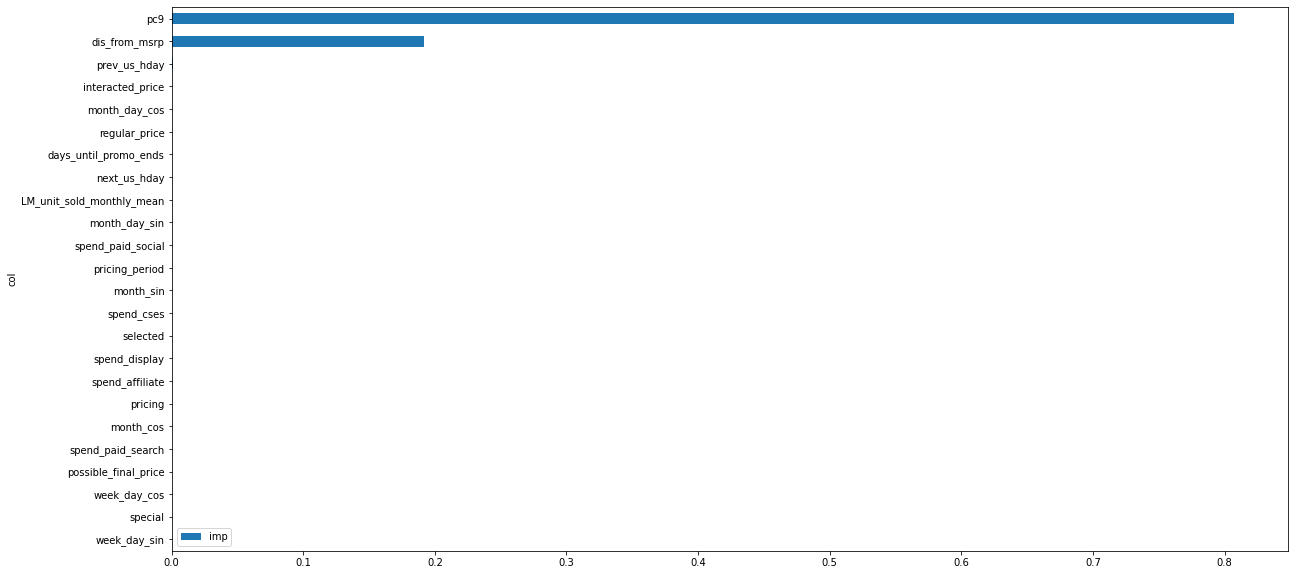

In [51]:
feat= ['pc9', 'days_until_promo_ends', 'next_us_hday', 'prev_us_hday', 'interacted_price', 'pricing', 'regular_price', 'spend_paid_social',
       'spend_paid_search', 'spend_affiliate', 'spend_cses', 'spend_display', 'special', 'pricing_period', 'possible_final_price', 'selected', 'month_sin', 'month_cos',
       'month_day_sin', 'month_day_cos', 'week_day_sin', 'week_day_cos','dis_from_msrp',
      #  'avg_toq_per_week',
       'LM_unit_sold_monthly_mean']
data_trainX = data_train[feat].copy()
feature_importance(model, data_trainX)

In [ ]:
# i = 100
# print (valy[i:i+10])
# print (yhat[i:i+10])

print ('Total validatio {}. Total predicted {}'.format(valy.sum(), yhat.sum()))
print ((yhat.sum()-valy.sum())/valy.sum())

In [32]:
!pip install catboost

     |████████████████████████████████| 76.4 MB 30 kB/s 


In [33]:
import catboost as cb

In [34]:
cat_model = cb.CatBoostRegressor(objective = 'Poisson', depth = 8, iterations = 50, od_type = 'Iter', learning_rate = 0.2)
# cat_model.fit(trainX,trainy, eval_set=(valX, valy))

In [37]:
def walk_forward_catboost(model, df_data, date_col = 'date', features = features, months=6, steep = 1):
    for i in range(months,0, -1):
        print(i)
        df_train, df_val = train_val_split(df_data, date_col=date_col, months=i)
        data_train = df_train[features].copy()
        data_val = df_val[features].copy()
        data_train = np.asarray(data_train)
        data_val = np.asarray(data_val)
        # split into input and output columns
        trainX, trainy = data_train[:, :-1], data_train[:, -1]
        valX, valy = data_val[:, :-1], data_val[:, -1]
        model.fit(trainX, trainy, eval_set=(valX, valy), silent = True)
        yhat = model.predict(valX)
        print ('MAE: ', mean_absolute_error(valy, yhat))
        print ('RMSE: ', mean_squared_error(valy, yhat, squared=False))
        print ('Total validatio {}. Total predicted {}'.format(valy.sum(), yhat.sum()))
        print ((yhat.sum()-valy.sum())/valy.sum())


In [38]:
walk_forward_catboost(cat_model, df_final, date_col = 'date', features = features, months=6, steep = 1)

6
Validation from 2021-02-06 00:00:00 to 2021-03-06 00:00:00


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MAE:  1.617848870657006
RMSE:  3.2053343411020316
Total validatio 23375.0. Total predicted 16337.257394915334
-0.30107989754372905
5
Validation from 2021-03-06 00:00:00 to 2021-04-06 00:00:00
MAE:  1.632604857194948
RMSE:  3.0042902420129667
Total validatio 31456.0. Total predicted 19929.616437592475
-0.36642877550888625
4
Validation from 2021-04-06 00:00:00 to 2021-05-06 00:00:00
MAE:  1.6362032873741483
RMSE:  3.540335961576266
Total validatio 31802.0. Total predicted 21506.05640301761
-0.3237514494994777
3
Validation from 2021-05-06 00:00:00 to 2021-06-06 00:00:00
MAE:  2.0321866645431084
RMSE:  5.379290469196504
Total validatio 41417.0. Total predicted 22756.907843577654
-0.4505418585706919
2
Validation from 2021-06-06 00:00:00 to 2021-07-06 00:00:00
MAE:  2.1667398904848034
RMSE:  5.034908144500443
Total validatio 45484.0. Total predicted 25181.262821435263
-0.4463709695401622
1
Validation from 2021-07-06 00:00:00 to 2021-08-06 00:00:00
MAE:  1.7658223556550439
RMSE:  3.6782869658

In [ ]:
pred_catboost = cat_model.predict(valX)

In [ ]:
mean_absolute_error(valy, pred_catboost)

In [ ]:
mean_squared_error(valy, pred_catboost, squared=False)

In [ ]:
print ('Total validatio {}. Total predicted {}'.format(valy.sum(), pred_catboost.sum()))
print ((pred_catboost.sum()-valy.sum())/valy.sum())

In [ ]:
feature_importance(cat_model, data_trainX)

In [ ]:
# i = 100
# print (valy[i:i+10])
# print (pred_catboost[i:i+10])

In [ ]:
# data_valid =  data[int(data.shape[0]*0.70):]
# data_valid.append(pd.Series(pred_catboost), ignore_index=True)
# data_valid

In [ ]:
from matplotlib import pyplot

In [ ]:
pyplot.plot(valy, label='Expected')
pyplot.plot(pred_catboost, label='Predicted')
pyplot.legend()
pyplot.show()

stop here

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
    print(agg.head())
    return agg.values

In [ ]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]



In [ ]:
def xgboost_forecast(train, testX):
    # transform list into array
    train = np.asarray(train)
    # split into input and output columns
    trainX, trainy = train[:, :-1], train[:, -1]
    # fit model
    model = xgboost.XGBRegressor(objective='reg:squarederror', n_estimators=1000, eval_metric = ['mae','rmse'])
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    return error, test[:, -1], predictions

In [ ]:
from matplotlib import pyplot

In [ ]:
d=[]
d = series_to_supervised(data, n_in=1, n_out=1)
print (d.shape, data.shape)
mae, y, yhat = walk_forward_validation(data.values, 10)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()